# Copying Random States and Using Multiple Augmentation Sequences

All other tutorials so far have assumed that only a single augmentation sequence is applied to all inputs. This tutorial explains how to use multiple augmentation sequences, and especially how to align the random number generation between these sequences. This is useful when augmenting images and heatmaps or segmentation maps on them. `imgaug` offers methods for heatmap and segmentation map augmentation, but these are geared towards ground truth data and will only apply geometry-affecting augmentations (e.g. gaussian noise or dropout are deactivated). If you do want to non-geometric augmentations, you will have to treat the heatmaps or segmentation maps as images and feed them through `augment_images()`, but then you might want to use augmenters and parameters that differ from the ones used for images, while still getting comparable results (e.g. crop amounts should match). This tutorial will show how to control the random number generation and thereby use multiple augmentation sequences with aligned randomness.

## Loading Base Data

The following example starts off with a standard scenario of having one image and a heatmap on it:

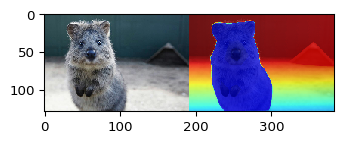

image min: 0.00, max: 255.00
heatmap min: 0.00, max: 1.00


In [1]:
import numpy as np
import imgaug as ia
%matplotlib inline
ia.seed(1)

# load image + heatmap
image = ia.quokka(size=0.2)  # uint8 array
heatmap = ia.quokka_heatmap(size=0.2)  # HeatmapsOnImage object, contains a float array

# show image + heatmap
ia.imshow(np.hstack([image, heatmap.draw_on_image(image)[0]]))

# print min/max of value ranges
print("image min: %.2f, max: %.2f" % (np.min(image), np.max(image)))
print("heatmap min: %.2f, max: %.2f" % (np.min(heatmap.get_arr()), np.max(heatmap.get_arr())))

## Example Problem

As you can see, the value ranges between the image (0 to 255) and heatmap (0.0 to 1.0) differ. Let's naively apply the same augmentation sequence to both image and heatmap, using both times `augment_image()`:

image min: 0.00, max: 255.00
heatmap min: -73.75, max: 77.37


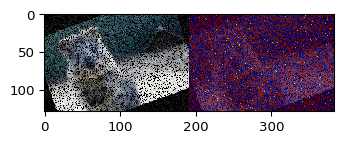

In [2]:
import imgaug.augmenters as iaa

# our augmentation sequence: affine rotation, dropout, gaussian noise
augs = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45)),
    iaa.Dropout(0.2),
    iaa.AdditiveGaussianNoise(scale=20)
])

# apply to image + heatmap
augs_det = augs.to_deterministic()
image_aug = augs_det.augment_image(image)
heatmap_aug = augs_det.augment_image(heatmap.get_arr())

# print min/max of value ranges
print("image min: %.2f, max: %.2f" % (np.min(image_aug), np.max(image_aug)))
print("heatmap min: %.2f, max: %.2f" % (np.min(heatmap_aug), np.max(heatmap_aug)))

# show results
ia.imshow(np.hstack([
    image_aug,
    ia.HeatmapsOnImage(
        np.clip(heatmap_aug, 0.0, 1.0),
        shape=image_aug.shape
    ).draw_on_image(image_aug)[0]
]))

## Manually Changing Parameter Values

The heatmap's value range is now very different compared to before. It changed from `[0.0, 1.0]` to `[-73.75, 77.37]`. This was caused here by `AdditiveGaussianNoise`, which sampled from a gaussian distribution following `N(0, 20)`. Such a large variance is aedequate for images, but not for heatmaps. The example below shows one way to fix this. We first copy the image-specific augmentation sequence to one for heatmaps. Then -- only in the heatmap-specific sequence -- we wrap the scale argument of `AdditiveGaussianNoise` in a `Multiply(..., 0.001)`, which decreases any sampled scale value by a factor of 1000.
(As the scale in the image-specific sequence was defined as a deterministic value of always `20`, we could also assign `iap.Deterministic(0.02)` and would have exactly the same outcome.)

image min: 0.00, max: 255.00
heatmap min: -0.07, max: 1.05


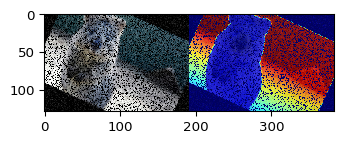

In [4]:
import imgaug.parameters as iap

# Ensure that all augmenters in 'augs' use their own random number generators,
# instead of using a global (shared) random number generator.
augs = augs.localize_random_state(recursive=True)

# Now copy augs to create an augmentation sequence for heatmaps.
# This also copies all random number generators, which means that the
# augmenters will sample the same random numbers.
augs_heatmap = augs.deepcopy()

# Reduce the scale for heatmaps to `0.001 * scale_for_images`.
# Here, this is the same as
#   augs_heatmap[2].value.scale.value = iap.Deterministic(0.2)
# because the scale was defined above as scale=20 and hence was a deterministic value.
# Note that it would be .value.scale.value and not just .scale, because AdditiveGaussianNoise
# returns an instance of AddElementwise, which adds values sampled from .value to images,
# where .value is a gaussian distribution with .value.scale.value.
augs_heatmap[2].value = iap.Multiply(augs_heatmap[2].value, 0.001)

# Augment images and heatmaps.
# We can skip here calling to_deterministic(), as both sequences
# already use the exactly same random number generators.
image_aug = augs.augment_image(image)
heatmap_aug = augs_heatmap.augment_image(heatmap.get_arr())
print("image min: %.2f, max: %.2f" % (np.min(image_aug), np.max(image_aug)))
print("heatmap min: %.2f, max: %.2f" % (np.min(heatmap_aug), np.max(heatmap_aug)))

ia.imshow(np.hstack([
    image_aug,
    ia.HeatmapsOnImage(
        np.clip(heatmap_aug, 0.0, 1.0),
        shape=image_aug.shape
    ).draw_on_image(image_aug)[0]
]))

As you can see, the value range of the augmented heatmaps is now much more appropriate. It is slightly outside the desired value range of `[0.0, 1.0]`, but that can be handled after augmentation by clipping.

## Using copy_random_state()

The above schema still has a noteworthy disadvantage: You would have to find out how exactly the parameters to replace are saved and how to replace their values. An easier solution is however available, which is based on instantiating two sequences in the standard way with slightly different parameters, and then copying the randomness from one sequence to the other one. The only requirement for a successful copy is to assign a unique name to each augmenter. Make sure that the names match between the two sequences so that the same augmenter gets the same name. Then copy once the random states from one sequence to the other and you are good to go. Example:

image min: 0.00, max: 255.00
heatmap min: -0.08, max: 1.05


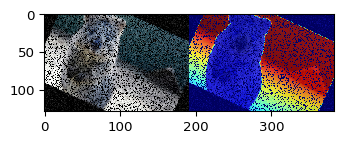

In [5]:
# Create image-specific augmentation sequence.
# Give each augmenter its own name.
sequence_images = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45), name="affine"),
    iaa.Dropout(0.2, name="dropout"),
    iaa.AdditiveGaussianNoise(scale=20, name="gauss-noise")
])

# Create heatmap-specific augmentation sequence.
# Make sure that the names are the same for augmenters that are supposed to be aligned!
# Note how the scale of AdditiveGaussianNoise is much lower than in the image-specific sequence.
sequence_heatmaps = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45), name="affine"),
    iaa.Dropout(0.2, name="dropout"),
    iaa.AdditiveGaussianNoise(scale=0.02, name="gauss-noise")  # different!
])

# Copy once the random states between the sequences by name.
# As before, first make sure that the source augmentation sequence
# uses its own random states instead of global (shared) random states.
# Now both sequences will follow the same sampling behaviour.
sequence_images = sequence_images.localize_random_state(recursive=True)
sequence_heatmaps_det = sequence_heatmaps.copy_random_state(sequence_images, matching="name")

# We can skip deterministic mode again, because both sequences have the same
# random states anyways.
image_aug = sequence_images.augment_image(image)
heatmap_aug = sequence_heatmaps.augment_image(heatmap.get_arr())
print("image min: %.2f, max: %.2f" % (np.min(image_aug), np.max(image_aug)))
print("heatmap min: %.2f, max: %.2f" % (np.min(heatmap_aug), np.max(heatmap_aug)))

ia.imshow(np.hstack([
    image_aug,
    ia.HeatmapsOnImage(
        np.clip(heatmap_aug, 0.0, 1.0),
        shape=image_aug.shape
    ).draw_on_image(image_aug)[0]
]))

## Using Seeds

You may wonder: If we just want the augmenters in both sequences to use similar random states, can we maybe define these random states already when instantiating these augmenters? Then we could make sure that the same augmenters get the same random states. And yes, that is possible. Every augmenter has a `random_state` argument. You can use this argument to provide a `numpy.random.RandomState` instance or simply a seed value. This makes it almost trivial to align the two sequences, as the example below shows. Note that this time we not only change the value ranges between the augmentation sequences, but also add different augmenters to both of them. This does not affect the assigned random states of the remaining augmenters. Keep in mind though that here we can only use different positions of the augmenters between the sequences, because we did not activate `random_order` in `Sequential`. Otherwise we would get mismatches, as the second augmenter in the image-sequence sequence differs from the second in the heatmap-sequence.

image min: 0.00, max: 255.00
heatmap min: -0.08, max: 1.05


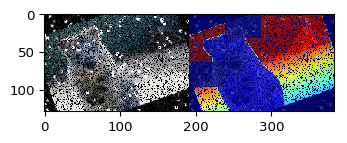

In [6]:
ia.seed(1)  # to make Snowflakes reproducible

# Image-specific sequence.
sequence_images = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45), random_state=1),
    iaa.Snowflakes(),  # added!
    iaa.Dropout(0.2, random_state=2),
    iaa.AdditiveGaussianNoise(scale=20, random_state=3)
], random_state=4)

# Heatmap-specific sequence.
# Make sure to use the same random state seeds as above.
sequence_heatmaps = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45), random_state=1),
    iaa.Dropout(0.2, random_state=2),
    iaa.CoarseDropout(0.2, size_px=4, random_state=100),  # added!
    iaa.AdditiveGaussianNoise(scale=0.02, random_state=3)
], random_state=4)

# We can skip deterministic mode again, because both sequences have the same
# random states anyways.
image_aug = sequence_images.augment_image(image)
heatmap_aug = sequence_heatmaps.augment_image(heatmap.get_arr())
print("image min: %.2f, max: %.2f" % (np.min(image_aug), np.max(image_aug)))
print("heatmap min: %.2f, max: %.2f" % (np.min(heatmap_aug), np.max(heatmap_aug)))

ia.imshow(np.hstack([
    image_aug,
    ia.HeatmapsOnImage(
        np.clip(heatmap_aug, 0.0, 1.0),
        shape=image_aug.shape
    ).draw_on_image(image_aug)[0]
]))